In [3]:
#imports
import mrmr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)

### data preparation

In [4]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [5]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [6]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#train 0.8
#test 0.2

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [7]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

### model class, train and evaluate functions

In [8]:
#convert, pandas to loader
def make_loader(X,y,batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
            
    x_tensor=torch.tensor(X.values, dtype=torch.float32)
    y_tensor=torch.tensor(y.values, dtype=torch.float32)
    set_object=TensorDataset(x_tensor,y_tensor)
    loader_object=DataLoader(dataset=set_object,batch_size=batch)
    return loader_object

In [9]:
#NN class
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super(NeuralNetwork,self).__init__()
        
        self.linear_tanh_stack=nn.Sequential(
            nn.Linear(input_size,4),
            nn.Tanh(),
            nn.Linear(4,4),
            nn.Tanh(),
            nn.Linear(4,1)
        )
        
    def forward(self,x):
        forward_pass=self.linear_tanh_stack(x)
        return forward_pass

In [10]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    model.eval()
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [11]:
#train and store all errors =)
def train_fn(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    for epoch in range(epochs):
        model.train() 
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [12]:
#train and not store all errors, i will use this one on the building of the tables, will speed up things...
def train_fn_no_loss(TrainLoader, model, loss_fn, optimizer,epochs):
    
    for epoch in range(epochs):
        model.train() 
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
    return model

### Simple loss plot example

In [15]:
torch.manual_seed(4000)
train_loader=make_loader(X=x_train,y=y_train,batch=32)
test_loader=make_loader(X=x_test,y=y_test,batch=32)

model=NeuralNetwork(input_size=401)
loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters())

In [16]:
epochs=200
model, train_loss, test_loss=train_fn(TrainLoader=train_loader,
                                   TestLoader=test_loader, 
                                   model=model, 
                                   loss_fn=loss_fn, 
                                   optimizer=optimizer,
                                   epochs=epochs)

(0.0, 0.75)

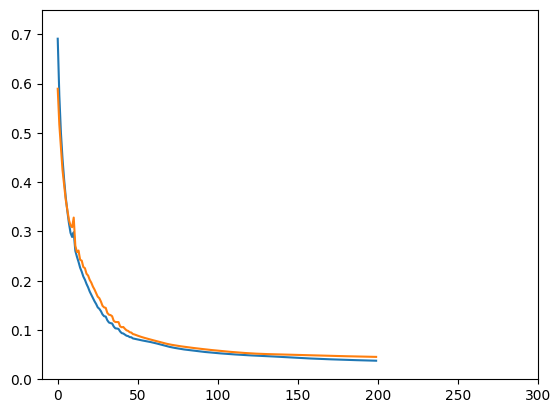

In [17]:
plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),test_loss)
plt.xlim(-10,300)
plt.ylim(0,0.75)

### permutation importance functions

In [18]:
#permutation importance from scikitlearn internally uses the predict function and checks for the presence
#of the fit function. if i feed my pytorch model inside a wrapper scikitlearn allows me tu use it's function =)
class PyTorchRegressorWrapper:
    def __init__(self, model):
        model = model

    def fit(self, X, y):
        #this function only needs to exhist to fulfill API contract with scikitlearn
        pass

    def predict(self, X):
        model.eval()
        with torch.no_grad():
            #convert to numpy as needed
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()

            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = model(X_tensor).numpy()
        return predictions

In [19]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_loss(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    train_loss_fold=[[],[],[],[],[]]
    val_loss_fold=[[],[],[],[],[]]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[train_idx]
        y_train_fold=y_train.iloc[train_idx]
        x_val_fold=X_train.iloc[val_idx]
        y_val_fold=y_train.iloc[val_idx]
        
        torch.manual_seed(4000)
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=10)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=10)

        model=NeuralNetwork(input_size=401)
        loss_fn=nn.MSELoss()
        optimizer=optim.Adam(model.parameters())
        
        epochs=200
        model, train_loss_fold[fold], val_loss_fold[fold]=train_fn(TrainLoader=train_loader_fold,
                                                                   TestLoader=test_loader_fold, 
                                                                   model=model, 
                                                                   loss_fn=loss_fn, 
                                                                   optimizer=optimizer,
                                                                   epochs=epochs)
        
        # pass model trough wrapper
        model_wrapper = PyTorchRegressorWrapper(model=model)

        # permutation importance with the wrapper instance
        results = permutation_importance(model_wrapper,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances, train_loss_fold, val_loss_fold


In [20]:
#this function returns the indexes to sice the n most important features
def perm_imp_get_topn_indexes(perm_imp_output,top_n):
    
    importance=pd.DataFrame(perm_imp_output)
    importance_sorted=importance.sort_values(by=0, ascending=False)
    
    bestn=importance_sorted.head(top_n)
    values=bestn.index
    
    return values

In [21]:
def build_table(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,30,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train=x_train[important_idx]
        x_test=x_test[important_idx]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[train_idx]
            y_train_fold=y_train.iloc[train_idx]
            x_val_fold=x_train.iloc[val_idx]
            y_val_fold=y_train.iloc[val_idx]
            
            torch.manual_seed(4000)
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=10)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=10)

            model=NeuralNetwork(input_size=features)
            loss_fn=nn.MSELoss()
            optimizer=optim.Adam(model.parameters())
            
            epochs=200
            model=train_fn_no_loss(TrainLoader=train_loader_fold, 
                                   model=model, 
                                   loss_fn=loss_fn, 
                                   optimizer=optimizer,
                                   epochs=epochs)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        torch.manual_seed(4000)
        train_loader=make_loader(X=x_train,y=y_train,batch=10)
        test_loader=make_loader(X=x_test,y=y_test,batch=10)

        model=NeuralNetwork(input_size=features)
        loss_fn=nn.MSELoss()
        optimizer=optim.Adam(model.parameters())
            
        epochs=200
        model=train_fn_no_loss(TrainLoader=train_loader, 
                               model=model, 
                               loss_fn=loss_fn, 
                               optimizer=optimizer,
                               epochs=epochs)
        
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss]
            
    return stored

In [132]:
importances,train_loss_list,val_loss_list=permutation_importance_loss(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

mean_importance=importances.mean(axis=1)

In [133]:
table = build_table(x_train=x_train,
                    y_train=y_train,
                    x_test=x_test,
                    y_test=y_test,
                    step=20,
                    perm_imp_array=mean_importance,
                    k_folds=5)

In [135]:
pd.set_option('display.precision', 3)
table

,train mse,train std,val mse,val std,calibration mse,test mse
401,0.051,0.020,0.086,0.039,0.047,0.041
381,0.040,0.012,0.093,0.024,0.036,0.035
361,0.049,0.014,0.086,0.030,0.043,0.046
341,0.039,0.014,0.079,0.025,0.035,0.032
321,0.042,0.016,0.085,0.045,0.031,0.037
301,0.047,0.015,0.080,0.034,0.040,0.036
281,0.049,0.015,0.080,0.032,0.032,0.044
261,0.041,0.020,0.077,0.024,0.033,0.033
241,0.039,0.014,0.066,0.023,0.037,0.039
221,0.039,0.009,0.068,0.019,0.052,0.054


### permutation importance example, with plotting of the kfolds loss

In [56]:
importances,train_loss_list,val_loss_list=permutation_importance_loss(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

mean_importance=importances.mean(axis=1)

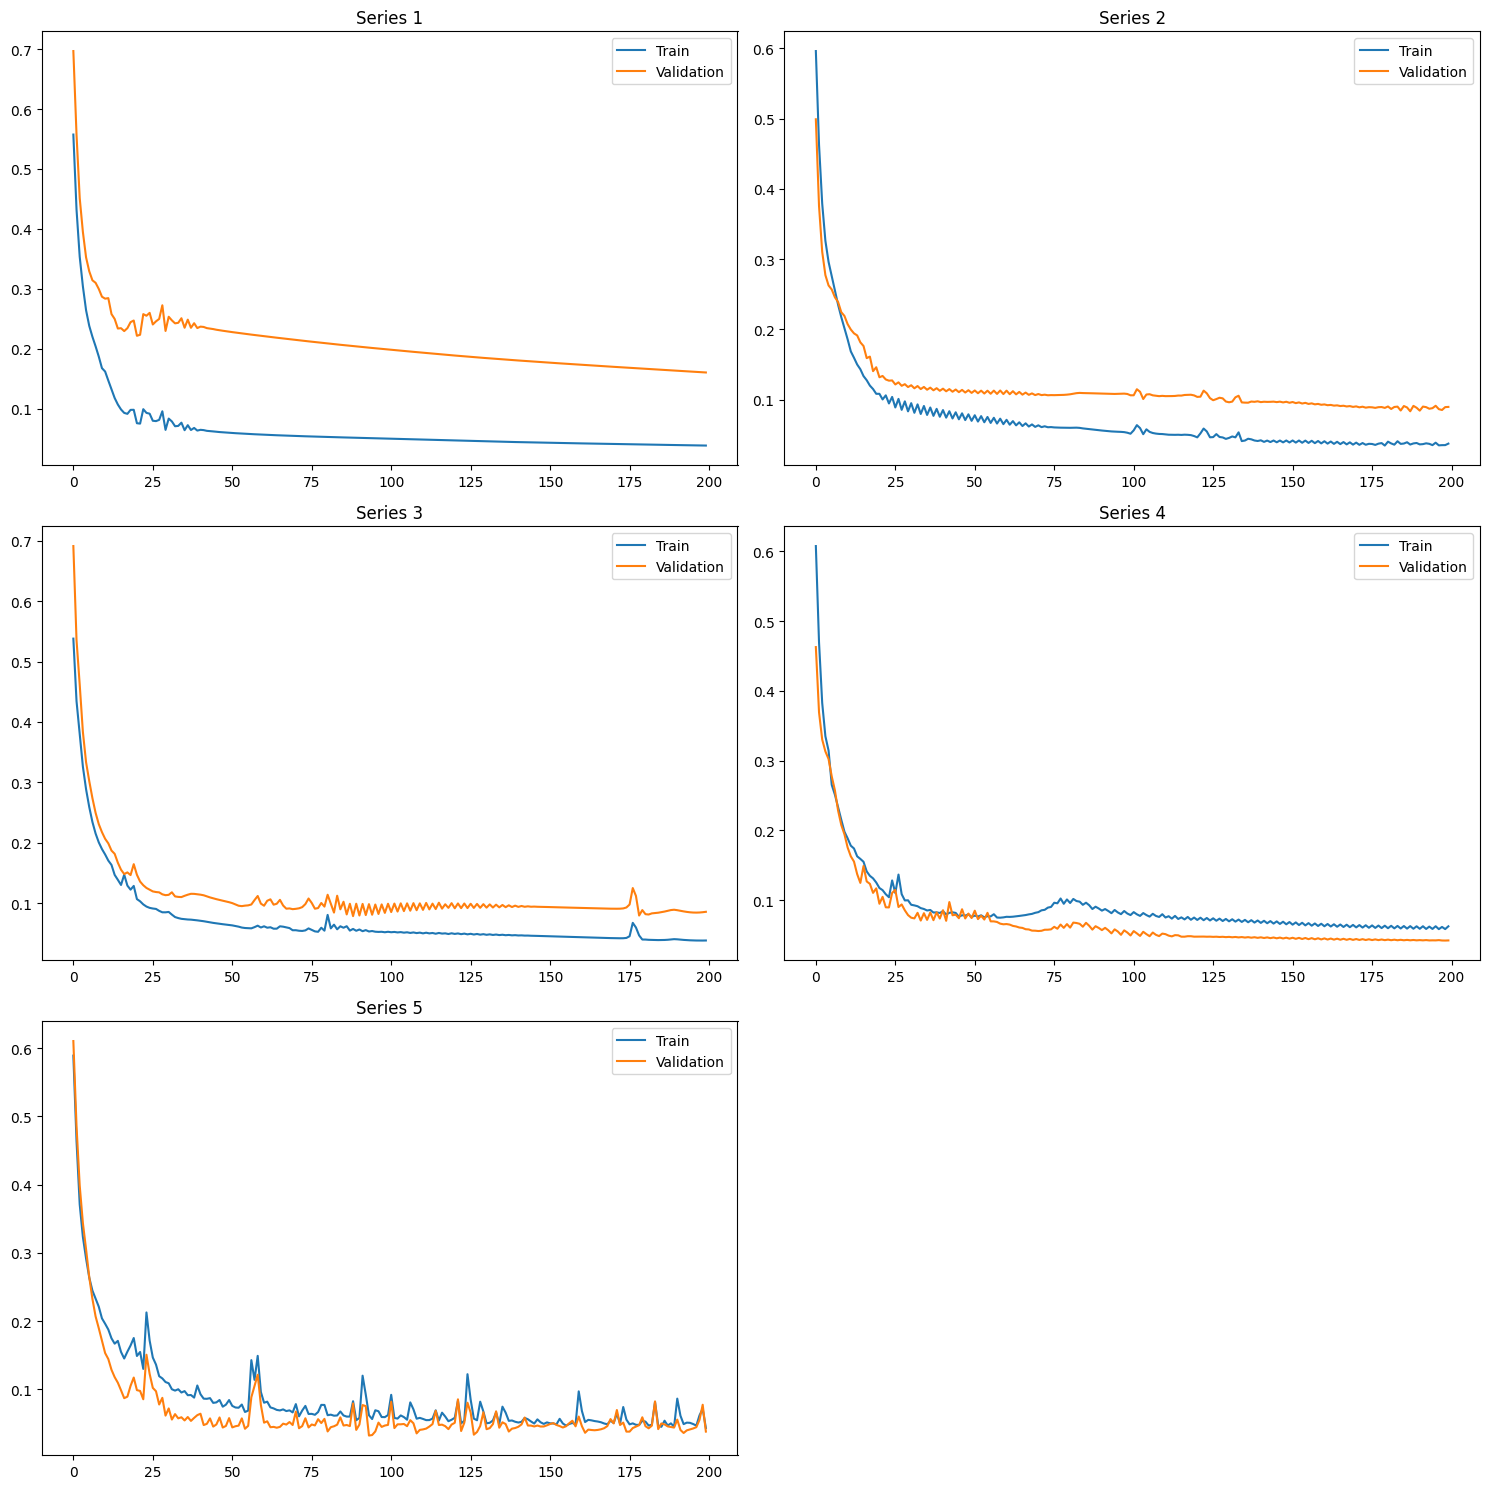

In [54]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()